In [17]:
import pandas as pd
from datetime import datetime as dt
import seaborn as sns

In [25]:
df = pd.read_csv("./extracted_files/contest_results.csv", parse_dates=["contest_date"])
df = df[['contest_date', 'contest_name', 'organization', 'division', 'class', 'competitor_name']]
df_pro_card = df[df['class'].str.contains('pro card')][['division', 'competitor_name']]

In [26]:
df_elo = pd.read_csv('contest_results_elo.csv', parse_dates=['contest_date'])

In [27]:
# find the elo rating for the competitor when they did their first pro show
df_ifbb_open = df_elo[(df_elo["organization"] == "ifbb") & (df_elo["class"] == "open")]
df_ifbb_open = pd.merge(df_ifbb_open, df_pro_card, how='inner', on=['division', 'competitor_name'])
df_ifbb_open.head()

,Unnamed: 0,organization,contest_name,contest_date,division,class,competitor_name,placing,elo_rating,elo_rank
0,17219,ifbb,ifbb pro grand prix,2012-04-14,women's physique,open,donna jones,13.0,1500.000000,5.0
1,17656,ifbb,ifbb emerald cup,2012-04-21,women's bodybuilding,open,tarna alderman,2.0,1500.000000,2.0
2,17953,ifbb,ifbb toronto pro,2012-06-01,bikini,open,pollianna moss,1.0,1580.067732,2.0
3,18038,ifbb,ifbb greater gulf states pro,2012-06-22,men's physique,open,trevor larsen,4.0,1603.083155,2.0
4,18151,ifbb,ifbb los angeles grand prix pro bikini,2012-07-21,bikini,open,katherine portillo,9.0,1669.304024,1.0


In [30]:
df_first_pro = pd.DataFrame(
    df_ifbb_open
    .groupby(["division", "competitor_name"])["contest_date"]
    .min()
).reset_index()
df_first_pro

,division,competitor_name,contest_date
0,bikini,abbi gaetano,2016-10-22
1,bikini,abby ball,2021-11-15
2,bikini,abigail fiala,2022-11-19
3,bikini,adriana hill,2012-08-11
4,bikini,adrienne crenshaw,2012-10-13
...,...,...,...
2924,women's physique,victoria settler,2017-08-04
2925,women's physique,virginia macon,2020-08-29
2926,women's physique,viridiana sanchez,2019-04-20
2927,women's physique,yasha,2015-06-20


In [31]:
df_first_pro_elo = pd.merge(df_ifbb_open, df_first_pro, on=['division', 'competitor_name', 'contest_date'])
df_first_pro_elo

,Unnamed: 0,organization,contest_name,contest_date,division,class,competitor_name,placing,elo_rating,elo_rank
0,17219,ifbb,ifbb pro grand prix,2012-04-14,women's physique,open,donna jones,13.0,1500.000000,5.0
1,17656,ifbb,ifbb emerald cup,2012-04-21,women's bodybuilding,open,tarna alderman,2.0,1500.000000,2.0
2,17953,ifbb,ifbb toronto pro,2012-06-01,bikini,open,pollianna moss,1.0,1580.067732,2.0
3,18038,ifbb,ifbb greater gulf states pro,2012-06-22,men's physique,open,trevor larsen,4.0,1603.083155,2.0
4,18151,ifbb,ifbb los angeles grand prix pro bikini,2012-07-21,bikini,open,katherine portillo,9.0,1669.304024,1.0
...,...,...,...,...,...,...,...,...,...,...
2989,74240,ifbb,ifbb sheru classic pro,2023-11-18,men's physique,open,surojit dey,12.0,1595.771365,7.0
2990,74256,ifbb,ifbb japan pro,2023-11-26,bikini,open,chu chieh,16.0,1599.451981,7.0
2991,74258,ifbb,ifbb japan pro,2023-11-26,bikini,open,karyse coley,16.0,1622.415064,6.0
2992,74323,ifbb,ifbb japan pro,2023-11-26,men's physique,open,seyednavid seyedaali nejad,9.0,1523.956483,16.0


In [34]:
df_starting_elo = pd.DataFrame(df_first_pro_elo.groupby(["division", "contest_date"])["elo_rating"].mean()).reset_index()
df_starting_elo['30dayrollavg_starting_elo'] = df_starting_elo.groupby(['division'])['elo_rating'].transform(lambda x: x.rolling(30, 1).mean())
df_starting_elo

,division,contest_date,elo_rating,30dayrollavg_starting_elo
0,bikini,2012-06-01,1580.067732,1580.067732
1,bikini,2012-07-21,1632.952595,1606.510163
2,bikini,2012-08-11,1594.606097,1602.542141
3,bikini,2012-08-18,1572.555726,1595.045538
4,bikini,2012-09-07,1585.719486,1593.180327
...,...,...,...,...
1102,women's physique,2023-09-29,1532.980527,1536.305002
1103,women's physique,2023-09-30,1506.468810,1535.011185
1104,women's physique,2023-10-07,1560.980821,1534.716493
1105,women's physique,2023-11-17,1597.591492,1536.599204


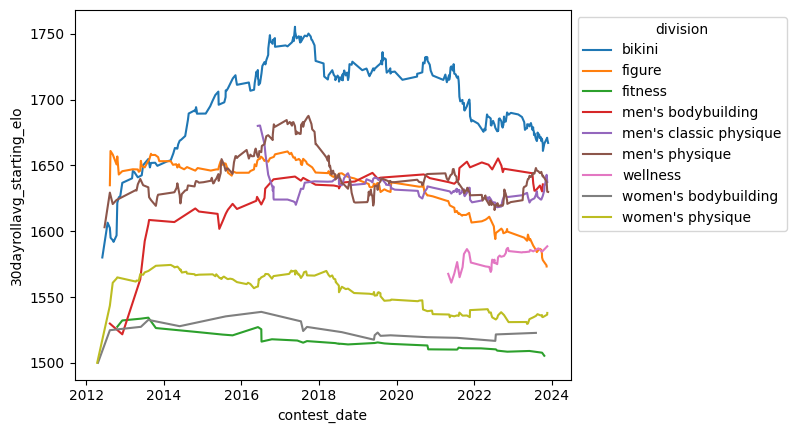

In [36]:
ax = sns.lineplot(
    data=df_starting_elo,
    x="contest_date",
    y="30dayrollavg_starting_elo",
    hue="division"
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [22]:
df[df['competitor_name'] == 'pricila rodriguez']['organization'].unique()

array(['ifbb'], dtype=object)